# ML — SVR Modeling (Clean Data Template)


Purpose
-------
Prepare cleaned, model-ready car-pricing data and evaluate Support Vector Regression baselines using the project's preprocessing utilities and feature-selection procedures.



Datasets used
--------------
- `Data/train.csv` — labeled training data
- `Data/test.csv` — unlabeled test data (used for final submission workflows)
- External vehicle models (downloaded from Kaggle: `vehicle models.json`)



Expected outputs
----------------
- A fitted `DataPreprocessor` instance for reproducible transforms
- A concise selected feature list (from feature-selection steps)
- Trained baseline models (SVR and optionally others) and saved model artifacts (pickle/joblib)
- Evaluation metrics: RMSE, MAE, R² (table)
- Diagnostic figures: predicted vs true, residuals, error distribution
- Optional: a submission CSV ready for Kaggle

## Table of Contents
- [Environment & Imports](#Environment--Imports)  
- [Data Loading](#Data-Loading)
- [Preprocessing Pipeline](#Preprocessing-Pipeline)  
- [Feature Engineering & Selection](#Feature-Engineering-&-Selection)
- [Train / Validation / Test Splits](#Train-/-Validation-/-Test-splits)
- [Model Definition & Training](#Model-Definition-&-Training)
- [Hyperparameter Search](#Hyperparameter-Search)
- [Model Evaluation & Diagnostics](#Model-Evaluation-&-Diagnostics)
- [Final Predictions & Submission](#Final-Predictions-&-Submission)
- [Conclusions & Next Steps](#Conclusions-&-Next-Steps)
- [Appendix & Utilities](#Appendix-&-Utilities)

## Data Loading
Load the primary datasets into pandas DataFrames and run a very short inspection (shape, dtypes, top rows, and missing-value counts). Keep heavy EDA in a separate notebook to keep this file concise.

In [1]:
import pandas as pd
import numpy as np
import os
import json
import kagglehub
import warnings
import traceback
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

import itertools
import random

# Load preprocessing classes
os.chdir('../')  # Change to project root directory
# Preprocessing and utility imports
from utils.preprocessing.CarDatabase import ProductionCarMatcher, create_optimized_database
from utils.preprocessing.Cardinal_Preprocessor import CardinalMapper



print("SIMPLE ML TEMPLATE - FAST CLEAN DATA")
print("=" * 45)


param_grid_svr = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly']
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}


# CONFIGURATION - Change these as needed
CONFIG = {

    'random_state': 42,
    'target_column': 'price',
    
    # Preprocessing options
    'outlier_removal': True,          # Remove outliers?
    'feature_scaling': True,          # Scale features?
    'encoding_method': 'onehot',        # 'mean', 'onehot'
    
    # Feature transformations
    'log_transform_mileage': True,    # Log transform mileage?
    'convert_year_to_age': True,      # Convert year to car age?
    'normalize_paint': True,          # Normalize paint quality to 0-1?
    'normalize_engine': True,         # Convert engine size units?
    
    # Data splitting
    'test_size': 0.2,                 # Proportion of data for testing
    'feature_selection_size': 0.16,   # Proportion of training data for feature selection
    
    # Model selection
    'n_splits': 5,                   # Number of reppetead K-Fold splits
    'n_repeats': 5,                  # Number of repeats for K-Fold
    
    # Toggle a short search for fast iteration (set to False for full grid)
    'SHORT_SEARCH': False,
    'MAX_COMBINATIONS': 3,                              # when SHORT_SEARCH=True, sample up to this many combinations
    'model_class': RandomForestRegressor,               # can be SVR, RandomForestRegressor, MLPRegressor
    'param_grid': param_grid_rf                        # can be param_grid_svr, param_grid_rf, etc.
}
if CONFIG['SHORT_SEARCH']:
    CONFIG['n_splits'] = 2
    CONFIG['n_repeats'] = 2
    print("WARNING: SHORT_SEARCH is enabled. Using a subset of data and parameter combinations for quick testing, not for final evaluation.")
print(f"Configuration: {CONFIG}")

/opt/anaconda3/envs/ML_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SIMPLE ML TEMPLATE - FAST CLEAN DATA
Configuration: {'random_state': 42, 'target_column': 'price', 'outlier_removal': True, 'feature_scaling': True, 'encoding_method': 'onehot', 'log_transform_mileage': True, 'convert_year_to_age': True, 'normalize_paint': True, 'normalize_engine': True, 'test_size': 0.2, 'feature_selection_size': 0.16, 'n_splits': 5, 'n_repeats': 5, 'SHORT_SEARCH': False, 'MAX_COMBINATIONS': 3, 'model_class': <class 'sklearn.ensemble._forest.RandomForestRegressor'>, 'param_grid': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}}


## Data Loading
Loads the raw CSV files into pandas DataFrames and performs a quick sanity check (shape, dtypes, head, missing values). Run this cell before the preprocessing pipeline.

In [2]:
# Load datasets and quick sanity checks
raw_train_data = pd.read_csv('Data/train.csv')
test_data = pd.read_csv('Data/test.csv')
if CONFIG['SHORT_SEARCH']:
    raw_train_data = raw_train_data.sample(n=500, random_state=CONFIG['random_state']).reset_index(drop=True)
    test_data = test_data.sample(n=200, random_state=CONFIG['random_state']).reset_index(drop=True)

print(f"Loaded: train -> {raw_train_data.shape}, test -> {test_data.shape}")

print('\n--- Train dtypes ---')
print(raw_train_data.dtypes)

print('\n--- Train head (5 rows) ---')
display(raw_train_data.head(5))

print('\n--- Top 10 missing counts (train) ---')
print(raw_train_data.isnull().sum().sort_values(ascending=False).head(10))

missing_pct = (raw_train_data.isnull().mean() * 100).sort_values(ascending=False).head(10)
print('\n--- Top 10 missing percent (train) ---')
print(missing_pct.round(2))

# Keep canonical variable names used later in the notebook
train_data = raw_train_data.copy()


Loaded: train -> (75973, 14), test -> (32567, 13)

--- Train dtypes ---
carID               int64
Brand              object
model              object
year              float64
price               int64
transmission       object
mileage           float64
fuelType           object
tax               float64
mpg               float64
engineSize        float64
paintQuality%     float64
previousOwners    float64
hasDamage         float64
dtype: object

--- Train head (5 rows) ---


,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
1,53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
2,6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
3,29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
4,10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0



--- Top 10 missing counts (train) ---
mpg               7926
tax               7904
previousOwners    1550
hasDamage         1548
paintQuality%     1524
transmission      1522
Brand             1521
model             1517
engineSize        1516
fuelType          1511
dtype: int64

--- Top 10 missing percent (train) ---
mpg               10.43
tax               10.40
previousOwners     2.04
hasDamage          2.04
paintQuality%      2.01
transmission       2.00
Brand              2.00
model              2.00
engineSize         2.00
fuelType           1.99
dtype: float64


## Preprocessing Pipeline Explanation
This section explains the high-level purpose of preprocessing and shows a minimal example of using the project's `DataPreprocessor` to produce model-ready features (X) and target (y).

Why & what
-----------
- Why: Ensure consistent handling of missing values, outliers, encoding and scaling so models receive reproducible, comparable inputs.
- What: Use `utils.preprocessing.DataPreprocessor` to encapsulate feature pipelines (imputation, transforms, encoding, scaling). Keep detailed pipeline code in `utils/` and call it from the notebook.

Contract
--------
- Inputs: Raw pandas DataFrame (must contain the target column defined in `CONFIG['target_column']`).
- Outputs: X (DataFrame of processed features), y (Series of target values).
- Errors: Missing target or required columns will raise a clear exception. Keep datasets sampled during development to speed iteration.

```python
# Minimal example usage of DataPreprocessor (high-level)
from utils.preprocessing.Preprocessor_divided import DataPreprocessor
from utils.preprocessing.Cardinal_Preprocessor import CardinalMapper
import joblib

# Initialize preprocessor (detailed pipelines live in `utils/` and/or are configured below using `feature_configs`)
preprocessor = DataPreprocessor(target_column=CONFIG['target_column'])

# Example: add a couple of feature pipelines in-place (keep full config in `feature_configs` later)
preprocessor.add_feature_pipeline('mileage', missing_strategy='median', transform_func=(log_transform if CONFIG.get('log_transform_mileage') else None), scaling_method=('standard' if CONFIG.get('feature_scaling') else None))
preprocessor.add_feature_pipeline('year', missing_strategy='mean', transform_func=(year_to_age if CONFIG.get('convert_year_to_age') else None), scaling_method=('minmax' if CONFIG.get('feature_scaling') else None))

# Fit-transform on a small sample for quick iteration (swap to full `train_data` when ready)
sample_train = train_data.sample(frac=0.2, random_state=CONFIG['random_state'])
X_sample, y_sample = preprocessor.fit_transform(sample_train)

print(f"Preprocessor fit on sample -> X: {X_sample.shape}, y: {y_sample.shape}")

# Persist fitted preprocessor for reproducibility (optional)
joblib.dump(preprocessor, 'artifacts/fitted_preprocessor_sample.joblib')
```


## Preprocessing Pipeline
Why & What
- Why: Convert raw, messy car data into a reproducible, model-ready feature matrix (X) and target vector (y).
- What: We reuse the project's preprocessing utilities in `utils/preprocessing/` (e.g., `DataPreprocessor`, `CardinalMapper`) so the notebook stays high-level.



Contract (short)
- Inputs: `train_data` DataFrame with expected raw columns, `CONFIG` and `feature_configs` defined above.
- Outputs: `X` (DataFrame), `y` (Series), and a fitted `preprocessor` object.
- Error modes: missing target column will raise; unexpected/missing features will be skipped with a warning.

In [3]:
raw_train_data = pd.read_csv('Data/train.csv')
test_data = pd.read_csv('Data/test.csv')
path = kagglehub.dataset_download("bourzamraid/global-car-make-and-model-list")
with open(os.path.join(path, 'vehicle models.json'), 'r') as f:
    kaggle_data = json.load(f)
        
# Create matcher and clean brands
optimized_db = create_optimized_database(kaggle_data, max_model_words=3)
matcher = ProductionCarMatcher(optimized_db)
        
_, train_data_results  =  matcher.clean_dataframe(raw_train_data,
                                        'Brand',
                                        'model')
_, test_data_results  =  matcher.clean_dataframe(test_data,
                                        'Brand',
                                        'model')
# concat the cleaned data with the target column
train_data = pd.concat([raw_train_data.loc[train_data_results.index], train_data_results[['clean_make', 'clean_model']]], axis=1)
test_data = pd.concat([test_data.loc[test_data_results.index], test_data_results[['clean_make', 'clean_model']]], axis=1)
# dorp Brand and model columns
train_data = train_data.drop(columns=['Brand', 'model'])
test_data = test_data.drop(columns=['Brand', 'model'])

fueltype_dict = {
    'Petrol': (['petrol', 'petro', 'etrol', 'etro', 'petr', 'ptrol' ],
               [ 'diesel', 'hybrid', 'electric',  'other' ]),
    'Diesel': (['diesel', 'diese', 'iesel', 'iese', 'dise' ],
               [ 'petrol', 'hybrid', 'electric',  'other' ]),
    'Hybrid': (['hybrid', 'hybri', 'ybrid', 'ybri', 'hyb' ],
               [ 'petrol', 'diesel', 'electric',  'other' ]),
    'Electric': (['electric', 'elect', 'elec' ],
               [ 'petrol', 'diesel', 'hybrid',  'other' ]),
    'Other': (['other', 'othe', 'oth' ],
               [ 'petrol', 'diesel', 'hybrid',  'electric' ]) }

transmission_dict = {
    'Manual': ([ 'man', 'manual', 'm', 'stick', 'standard', 'mt' ],
               [ 'auto', 'semi', 'automatic', 'tiptronic', 'emi','mi','other' ]),
    'Semi-Auto': (['semi', 'semi-auto', 'tiptronic', 'emi','mi' ],
                    [ 'manual', 'stick', 'full manual', 'Other' ]),
    'Automatic': (['auto', 'automatic', 'a', 'at' ],
                  [ 'semi', 'manual', 'stick', 'tiptronic', 'emi','mi', 'other' ]) }


fuel_mapper = CardinalMapper(fueltype_dict)
transmission_mapper = CardinalMapper(transmission_dict)

print("Mapping fuelType and transmission columns...")
train_data['fuelType'] = fuel_mapper.fit_transform(train_data['fuelType'])
train_data['transmission'] = transmission_mapper.fit_transform(train_data['transmission'])
print(f"fuelType value counts:\n{train_data['fuelType'].value_counts()}")
test_data['fuelType'] = fuel_mapper.fit_transform(test_data['fuelType'])
test_data['transmission'] = transmission_mapper.fit_transform(test_data['transmission'])
print(f"transmission value counts:\n{train_data['transmission'].value_counts()}")


Analyzing word frequencies...
Created optimized database with 146 makes
Cleaning 75973 records...


Processing records: 100%|██████████| 75973/75973 [03:18<00:00, 382.76it/s]


Cleaning 32567 records...


Processing records: 100%|██████████| 32567/32567 [01:27<00:00, 373.34it/s]


Mapping fuelType and transmission columns...
fuelType value counts:
fuelType
Petrol      41181
Diesel      30885
Hybrid       2225
Other        1678
Electric        4
Name: count, dtype: int64
transmission value counts:
transmission
Manual       41627
Semi-Auto    16872
Automatic    15211
Other         2263
Name: count, dtype: int64


In [4]:
# Define transformations that can be applied to features
def log_transform(x:pd.Series)->pd.Series:
    return np.log1p(np.abs(x)+1)

def year_to_age(year_series:pd.Series)->pd.Series:
    return 2025 - np.abs(np.floor(year_series))

def normalize_paint(paint_series:pd.Series)->pd.Series:
    return np.clip(paint_series, 0, 100) / 100

def normalize_engine(engine_series:pd.Series)->pd.Series:
    result = engine_series.copy()
    small_engines = engine_series <= 10
    result[small_engines] = engine_series[small_engines] * 1000
    return result


In [5]:
from utils.preprocessing.Preprocessor_divided import DataPreprocessor

In [ ]:
# Configure features
feature_configs = {
    'mileage': {
        'missing_strategy': 'median',
        'outlier_method': 'iqr' if CONFIG['outlier_removal'] else None,
        'transform_func': log_transform if CONFIG['log_transform_mileage'] else None,
        'scaling_method': 'standard' if CONFIG['feature_scaling'] else None
    },
    'year': {
        'missing_strategy': 'mean',
        'transform_func': year_to_age if CONFIG['convert_year_to_age'] else None,
        'scaling_method': 'minmax' if CONFIG['feature_scaling'] else None
    },
    'engineSize': {
        'missing_strategy': 'median',
        'transform_func': normalize_engine if CONFIG['normalize_engine'] else None,
        'scaling_method': 'robust' if CONFIG['feature_scaling'] else None
    },
    'tax': {
        'transform_func': lambda x: np.abs(x),
        'missing_strategy': 'median',
        'scaling_method': 'standard' if CONFIG['feature_scaling'] else None
    },
    'mpg': {
        'transform_func': lambda x: np.abs(x),
        'missing_strategy': 'median',
        'outlier_method': 'iqr' if CONFIG['outlier_removal'] else None,
        'scaling_method': 'standard' if CONFIG['feature_scaling'] else None
    },
    'paintQuality%': {
        'missing_strategy': 'median',
        'transform_func': normalize_paint if CONFIG['normalize_paint'] else None,
        'scaling_method': 'minmax' if CONFIG['feature_scaling'] else None
    },
    'previousOwners': {
        'missing_strategy': 'median',
        'transform_func': lambda x: np.log1p(np.abs(np.floor(x))),
        'scaling_method': 'standard' if CONFIG['feature_scaling'] else None
    },
    'hasDamage': {
        'missing_strategy': 1,
        'scaling_method': None
    },
    'clean_make': {
        'missing_strategy': 'mode',
        'encoding_method': 'mean'  # use mean encoding for make in any case, regardless of CONFIG because of high cardinality
    },
    'clean_model': {
        'missing_strategy': 'mode',
        'encoding_method': 'mean', # use mean encoding for models in any case, regardless of CONFIG because of high cardinality
    },
    'transmission': {
        'missing_strategy': 'mode',
        'encoding_method': CONFIG['encoding_method'],

    },
    'fuelType': {
        'missing_strategy': 'mode',
        'encoding_method': CONFIG['encoding_method'],
    }
}

In [27]:
data_temp = train_data.sample(frac=CONFIG['test_size'], random_state=CONFIG['random_state'])
data_val = train_data.drop(data_temp.index)
data_model_sel = data_temp.sample(frac=CONFIG['feature_selection_size'] , random_state=CONFIG['random_state'])
data_train = data_temp.drop(data_model_sel.index)

print(f"\n DATA SPLIT COMPLETE!")
print(f"   data_train: {data_train.shape}")
print(f"   data_model_sel: {data_model_sel.shape}")
print(f"   data_val: {data_val.shape}")

# fit_transform training data and transform feature selection and validation data
preprocessor = DataPreprocessor(target_column=CONFIG['target_column'])


for feature, feature_config in feature_configs.items():
    if feature in data_train.columns:
        preprocessor.add_feature_pipeline(feature, **feature_config)  
        
# we are already transformun the partitions becuse during k-fold CV we are going to fit_transform again and we don't want to lose the transformations for the final model validation
X_train, y_train = preprocessor.fit_transform(data_train)
X_feature_sel, y_model_sel = preprocessor.transform(data_model_sel)
X_val, y_val = preprocessor.transform(data_val)
X_test, y_test = preprocessor.transform(train_data)
test_data_processed, _ = preprocessor.transform(test_data)
del data_temp  # free memory
print("\n Preprocessing complete.")
print(f"   X_train: {X_train.shape}")
print(f"   X_feature_sel: {X_feature_sel.shape}")
print(f"   X_val: {X_val.shape}")
print(f"   X_test: {X_test.shape}")
print(f"   test_data_processed: {test_data_processed.shape}")



 DATA SPLIT COMPLETE!
   data_train: (12764, 14)
   data_model_sel: (2431, 14)
   data_val: (60778, 14)

 Preprocessing complete.
   X_train: (12764, 19)
   X_feature_sel: (2431, 19)
   X_val: (60778, 19)
   X_test: (75973, 19)
   test_data_processed: (32567, 19)


# Data is Clean — Start Modeling
---

**Instantiated `DataPreprocessor` Object**

The reason we don't clean the dataset and save it as a new CSV file is to keep track of the preprocessing steps and be able to reproduce them on new data (e.g., test set, future data, cross-validation folds, etc.). This approach avoids data leakage, as encoding and scaling should be fitted only on the training data and then applied to the validation/test data. A fitted preprocessor can be saved and loaded later for consistent transformations.

---

#### Data Partitions

- **Feature Selection Data**: Allocated 16% of the original training set for feature selection procedures.
- **Train Data**: Allocated 60% of the original training set for fitting the preprocessor and training models.
- **Validation Data**: Allocated 24% of the original training set for hyperparameter tuning and model selection.


## Feature Selection
This section documents the engineered features we create and the approach used to select a compact, informative feature set for modeling.

Selection approach (short)
- Categorical selection: test mutual information, ANOVA, RF importance, and RFE variants, then compile an acceptance score.
- Numerical selection: VIF (multicollinearity), spearman redundancy/relevance, RFE, Lasso/Ridge ranking.
- We run selection on a dedicated holdout (`X_model_sel`, `y_model_sel`) to avoid leakages and to speed iteration.
- Final chosen features are the union of 'Keep' decisions from categorical and numerical selectors.


In [8]:
from utils.feature_selection.feature_selection import NumericalFeatureSelector, CategoricalFeatureSelector

### Boolean Feature Selection

In [9]:
# slect the colums with cardinality 2
boolean_features = X_feature_sel.columns[X_train.nunique() == 2].tolist()


# Categorical selector example (boolean_features should be defined earlier)
cat_selector = CategoricalFeatureSelector(
    X_train=X_feature_sel,
    y_train=y_model_sel,
    categorical_encoded_features=boolean_features,
    corr_threshold=0.8,
    importance_threshold=0.01
)

final_results_cat = cat_selector.compile_results()
display(final_results_cat.head(10))

,Feature,Low_Correlation,High_MI,ANOVA_Sig,RF_Important,RFE_DecisionTree,RFE_RandomForest,RFE_LR_MinMax,RFE_LR_Standard,RFE_LR_Robust,Lasso_MinMax,Lasso_Standard,Lasso_Robust,Total_Accepted,Accept_Rate,Final_Decision
0,hasDamage,False,False,False,True,False,False,False,False,False,False,False,False,1,0.083333,Drop
1,transmission_Automatic,True,True,True,False,False,False,True,True,True,True,False,True,8,0.666667,Keep
2,transmission_Manual,True,True,True,True,True,True,False,True,False,True,True,True,10,0.833333,Keep
3,transmission_Other,True,False,False,True,True,True,False,False,False,True,True,True,7,0.583333,Drop
4,transmission_Semi-Auto,True,True,True,True,True,True,True,True,True,True,True,True,12,1.000000,Keep
5,fuelType_Diesel,True,True,True,True,False,False,True,True,True,True,True,True,10,0.833333,Keep
6,fuelType_Hybrid,True,False,True,False,False,False,False,False,False,False,False,False,2,0.166667,Drop
7,fuelType_Other,True,False,False,False,False,False,True,False,True,False,True,False,4,0.333333,Drop
8,fuelType_Petrol,False,True,True,True,True,True,False,False,False,True,True,True,8,0.666667,Keep


### Numerical Feature Selection

In [10]:
# Numerical selector example
numerical_features = X_feature_sel.select_dtypes(include=[np.number]).columns.tolist()
# remove boolean features from numerical set if present
numerical_features = [f for f in numerical_features if f not in boolean_features]


num_selector = NumericalFeatureSelector(
    X_train=X_feature_sel,
    y_train=y_model_sel,
    numeric_features=numerical_features,
    vif_threshold=0.8,
    corr_threshold=0.8,
)

final_results_num = num_selector.compile_results()
display(final_results_num.head(10))

,Feature,VIF,Accepted_x,Max_SpearmanCorr,Accepted_y,Spearman_TargetCorr,Accepted,RFE_DecisionTree,RFE_RandomForest,RFE_LR_MinMax,RFE_LR_Standard,RFE_LR_Robust,Ridge_MinMax,Ridge_Standard,Ridge_Robust,Lasso_MinMax,Lasso_Standard,Lasso_Robust,Total_Accepted,Final_Decision
0,carID,3.766148,False,NaN,False,0.207561,True,False,False,False,False,False,True,True,True,True,True,True,7,Drop
1,year,11.196248,False,0.020019,True,0.599137,True,True,True,True,True,True,True,True,True,True,True,True,13,Keep
2,mileage,1.477808,False,0.785706,True,0.511561,True,True,True,True,True,True,True,True,True,True,True,True,13,Keep
3,tax,1.407148,False,0.321876,True,0.284726,True,False,False,False,False,False,True,True,True,True,True,True,8,Keep
4,mpg,1.516685,False,0.537881,True,0.361640,True,True,True,True,True,True,True,True,True,True,True,True,13,Keep
5,engineSize,1.527819,False,0.181542,True,0.539063,True,True,True,True,True,True,True,True,True,True,True,True,13,Keep
6,paintQuality%,8.492747,False,0.029246,True,0.024138,False,False,False,False,False,False,True,True,True,True,False,False,5,Drop
7,previousOwners,1.004861,False,0.051005,True,0.013220,False,False,False,False,False,False,True,True,True,True,False,False,5,Drop
8,clean_make,21.206874,False,0.518188,True,0.566163,True,False,False,False,False,False,True,True,True,True,True,True,8,Keep
9,clean_model,16.685976,False,0.751840,True,0.746939,True,True,True,True,True,True,True,True,True,True,True,True,13,Keep


### join final features

In [11]:
selected_boolean_features = final_results_cat[final_results_cat['Final_Decision'] == 'Keep']['Feature'].tolist()
selected_numerical_features = final_results_num[final_results_num['Final_Decision'] == 'Keep']['Feature'].tolist()


choosen_features = selected_numerical_features + selected_boolean_features
choosen_features

['year',
 'mileage',
 'tax',
 'mpg',
 'engineSize',
 'clean_make',
 'clean_model',
 'transmission_Automatic',
 'transmission_Manual',
 'transmission_Semi-Auto',
 'fuelType_Diesel',
 'fuelType_Petrol']

## Hyperparameter Search
This section runs a controlled hyperparameter search using the project's `run_hyperparameter_tuning` helper. Keep searches small while iterating (use `SHORT_SEARCH=True`) and scale up when you're ready to run the full grid.

What this cell does
- Build a parameter grid (dict of lists) for the chosen model.
- Convert the grid to a list of parameter dictionaries that `run_hyperparameter_tuning` accepts.
- Optionally sample a small subset of combinations for quick iteration.
- Run the search and return a `results` DataFrame and `best_params` dictionary.

Contract
- Inputs: `train_data` (raw DataFrame), `preprocessor` (fitted or configured `DataPreprocessor`), `CONFIG` for CV settings.
- Outputs: `results` (DataFrame), `best_params` (dict).
- Notes: `run_hyperparameter_tuning` will internally transform data using the provided preprocessor.

In [12]:
from utils.model_selection.model_selection import run_hyperparameter_tuning
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

Total SVR combinations: 27
Starting hyperparameter tuning for SVR — this may take a while depending on combos and CV
--- Starting RandomForestRegressor Hyperparameter Tuning (5x5 Folds) ---


Evaluating Folds: 100%|██████████| 25/25 [07:45<00:00, 18.63s/it]


Result: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2}-> mean_absolute_error=1379.5044 ± 6.8489


Evaluating Folds: 100%|██████████| 25/25 [07:07<00:00, 17.09s/it]


Result: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 5}-> mean_absolute_error=1377.9118 ± 6.7081


Evaluating Folds: 100%|██████████| 25/25 [06:41<00:00, 16.04s/it]


Result: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 10}-> mean_absolute_error=1381.8478 ± 6.9496


Evaluating Folds: 100%|██████████| 25/25 [04:20<00:00, 10.44s/it]


Result: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2}-> mean_absolute_error=1651.5605 ± 6.3804


Evaluating Folds: 100%|██████████| 25/25 [04:20<00:00, 10.40s/it]


Result: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}-> mean_absolute_error=1652.3728 ± 6.2482


Evaluating Folds: 100%|██████████| 25/25 [04:20<00:00, 10.42s/it]


Result: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 10}-> mean_absolute_error=1653.9754 ± 6.6449


Evaluating Folds: 100%|██████████| 25/25 [07:06<00:00, 17.07s/it]


Result: {'n_estimators': 50, 'max_depth': 20, 'min_samples_split': 2}-> mean_absolute_error=1376.0208 ± 6.8474


Evaluating Folds: 100%|██████████| 25/25 [06:45<00:00, 16.20s/it]


Result: {'n_estimators': 50, 'max_depth': 20, 'min_samples_split': 5}-> mean_absolute_error=1376.8444 ± 6.4019


Evaluating Folds: 100%|██████████| 25/25 [06:26<00:00, 15.48s/it]


Result: {'n_estimators': 50, 'max_depth': 20, 'min_samples_split': 10}-> mean_absolute_error=1381.7140 ± 6.7494


Evaluating Folds: 100%|██████████| 25/25 [15:20<00:00, 36.80s/it]


Result: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2}-> mean_absolute_error=1370.1872 ± 6.9631


Evaluating Folds: 100%|██████████| 25/25 [14:18<00:00, 34.34s/it]


Result: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 5}-> mean_absolute_error=1371.0890 ± 6.7643


Evaluating Folds: 100%|██████████| 25/25 [13:33<00:00, 32.53s/it]


Result: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 10}-> mean_absolute_error=1375.7595 ± 6.8102


Evaluating Folds: 100%|██████████| 25/25 [08:20<00:00, 20.02s/it]


Result: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2}-> mean_absolute_error=1648.3131 ± 6.4897


Evaluating Folds: 100%|██████████| 25/25 [08:22<00:00, 20.11s/it]


Result: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5}-> mean_absolute_error=1649.0458 ± 6.7235


Evaluating Folds: 100%|██████████| 25/25 [08:18<00:00, 19.95s/it]


Result: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10}-> mean_absolute_error=1650.9065 ± 6.4806


Evaluating Folds: 100%|██████████| 25/25 [13:58<00:00, 33.53s/it]


Result: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2}-> mean_absolute_error=1369.2781 ± 6.6658


Evaluating Folds: 100%|██████████| 25/25 [13:13<00:00, 31.72s/it]


Result: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 5}-> mean_absolute_error=1369.6848 ± 6.7948


Evaluating Folds: 100%|██████████| 25/25 [12:36<00:00, 30.27s/it]


Result: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 10}-> mean_absolute_error=1375.1500 ± 6.5477


Evaluating Folds: 100%|██████████| 25/25 [29:56<00:00, 71.87s/it]


Result: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2}-> mean_absolute_error=1365.8279 ± 6.6250


Evaluating Folds: 100%|██████████| 25/25 [28:16<00:00, 67.88s/it]


Result: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 5}-> mean_absolute_error=1366.2238 ± 6.5821


Evaluating Folds: 100%|██████████| 25/25 [25:42<00:00, 61.69s/it]


Result: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 10}-> mean_absolute_error=1372.2235 ± 6.6456


Evaluating Folds: 100%|██████████| 25/25 [16:19<00:00, 39.18s/it]


Result: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 2}-> mean_absolute_error=1647.2454 ± 6.4652


Evaluating Folds: 100%|██████████| 25/25 [16:16<00:00, 39.08s/it]


Result: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 5}-> mean_absolute_error=1647.9779 ± 6.5081


Evaluating Folds: 100%|██████████| 25/25 [16:19<00:00, 39.18s/it]


Result: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 10}-> mean_absolute_error=1649.9996 ± 6.8419


Evaluating Folds: 100%|██████████| 25/25 [27:38<00:00, 66.36s/it]


Result: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 2}-> mean_absolute_error=1364.0116 ± 6.6680


Evaluating Folds: 100%|██████████| 25/25 [26:07<00:00, 62.70s/it]


Result: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5}-> mean_absolute_error=1365.5428 ± 6.6744


Evaluating Folds: 100%|██████████| 25/25 [57:29<00:00, 137.99s/it]  


Result: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 10}-> mean_absolute_error=1373.6448 ± 6.8163

--- Generating Plot RandomForestRegressor ---


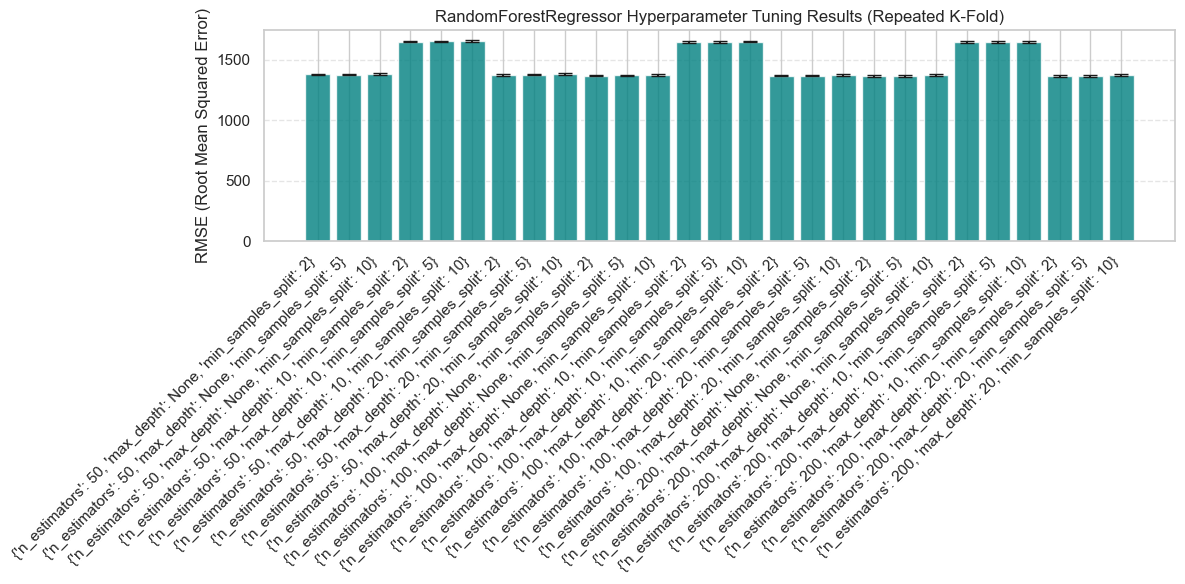


Optimization Complete. Best Parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 2} with Mean RMSE=1364.0116

Best parameters (SVR): {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 2}


In [13]:
# Convert to list of dicts (one dict per combination)
keys = list(CONFIG['param_grid'].keys())
values = list(CONFIG['param_grid'].values())
all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"Total {CONFIG['model_class'].__name__} combinations: {len(all_combinations)}")

if CONFIG['SHORT_SEARCH'] and len(all_combinations) > CONFIG['MAX_COMBINATIONS']:
    list_of_dictionaries = random.sample(all_combinations, CONFIG['MAX_COMBINATIONS'])
    print(f"SHORT_SEARCH active — sampling {len(list_of_dictionaries)} combinations")
else:
    list_of_dictionaries = all_combinations

# Run the helper. `run_hyperparameter_tuning` expects the raw train dataframe and a preprocessor to transform inside.
print(f"Starting hyperparameter tuning for {CONFIG['model_class'].__name__} — this may take a while depending on combos and CV")
results_svr, best_params = run_hyperparameter_tuning(
    train_data,
    preprocessor=preprocessor,
    list_of_dictionaries=list_of_dictionaries,
    metric=mean_absolute_error,
    model_class=CONFIG['model_class'],
    n_splits=CONFIG['n_splits'],
    n_repeats=CONFIG['n_repeats'],
    random_state=CONFIG['random_state']
 )

print(f"\nBest parameters ({CONFIG['model_class'].__name__}):", best_params)

# Model Definition & Final Training
Define the final model using the best hyperparameters found during the search, train it on

In [14]:
from utils.model_evaluation.regression_evaluation import get_regression_metrics, plot_regression_diagnostics

   Support Vector  RMSE: 2969
   Support Vector  R²: 0.908
   Support Vector MAE: 1598

Regression Metrics:
                                      Score  \
Metric                                       
R-squared ($R^2$)                   0.9079   
Explained Variance Score            0.9079   
Root Mean Squared Error (RMSE)  2,968.7927   
Mean Absolute Error (MAE)       1,597.8731   
Median Absolute Error (MedAE)     972.0656   

                                                                   Interpretation  
Metric                                                                             
R-squared ($R^2$)               Proportion of variance explained by the model ...  
Explained Variance Score        The variance in the error, a lower value is be...  
Root Mean Squared Error (RMSE)  Average magnitude of errors (same units as tar...  
Mean Absolute Error (MAE)       Average absolute difference between true and p...  
Median Absolute Error (MedAE)   The median of all absolute error

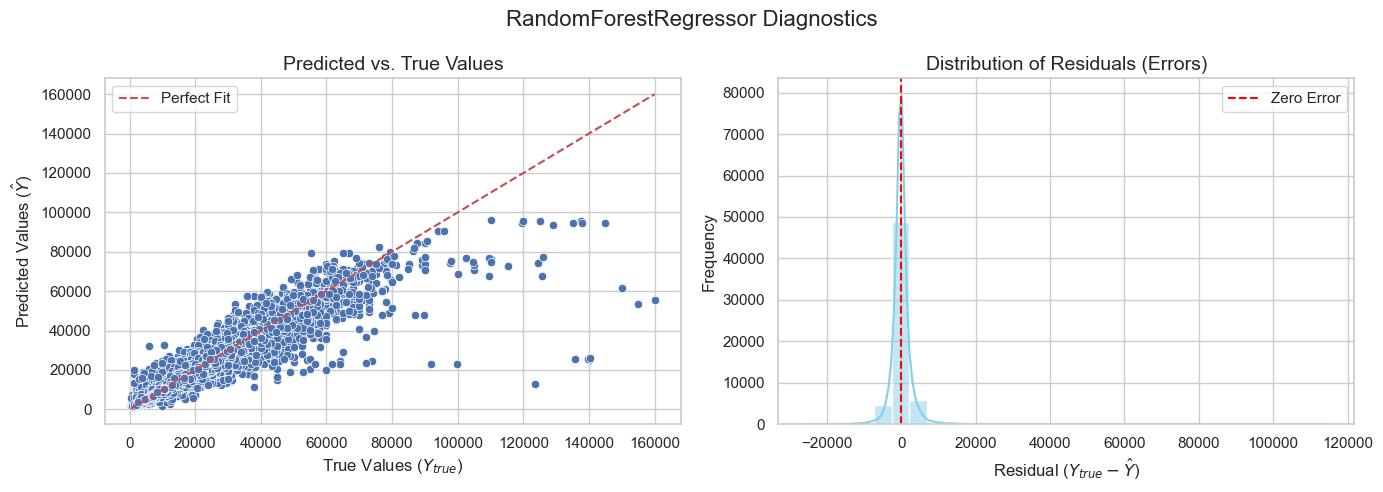

In [ ]:
from typing import Callable, Dict, List, TypeVar

def predict_and_evaluate_regressor(model_cls:Callable,
                                   choosen_params:Dict,
                                   choosen_features:List[str],
                                   X_train:pd.DataFrame,
                                   y_train:pd.Series,
                                   X_val:pd.DataFrame,
                                   y_val:pd.Series,
                                   save_report:bool=True,
                                   report_filename:str=None):
    

    
    model = model_cls(**choosen_params)
    model.fit(X_train[choosen_features], y_train)

    predictions = model.predict(X_val[choosen_features])
    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    mae = mean_absolute_error(y_val, predictions)
    r2 = r2_score(y_val, predictions)

    print(f"   Support Vector  RMSE: {rmse:.0f}")
    print(f"   Support Vector  R²: {r2:.3f}")
    print(f"   Support Vector MAE: {mae:.0f}")
    metrics_df = get_regression_metrics(y_val, predictions)
    print("\nRegression Metrics:\n", metrics_df)
    plot_regression_diagnostics(y_val, predictions, title=f"{CONFIG['model_class'].__name__} Diagnostics")
    
    if save_report:
        #make sure the filename ends with .txt
        if report_filename is None:
            todyas_date = pd.Timestamp.now().strftime("%Y%m%d")
            report_filename = f"{todyas_date}_{CONFIG['model_class'].__name__}_regression_report.txt"
        elif not report_filename.endswith('.txt'):
            report_filename += '.txt'
        with open(f"report_filename", "w") as f:
            f.write(f"Regression Metrics for {CONFIG['model_class'].__name__}:\n")
            f.write(f"Choosen Parameters: {choosen_params}\n\n")
            f.write(metrics_df.to_string())
            
    return model
    

model = predict_and_evaluate_regressor(model=CONFIG['model_class'],
                               X_train=X_train,
                               y_train=y_train,
                               X_val=X_val,
                               y_val=y_val,
                               choosen_features=choosen_features,
                               choosen_params=best_params,
                               save_report= not CONFIG['SHORT_SEARCH'],
                               report_filename=None)                               
                               

In [32]:
print(best_params)

{'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 2}


In [ ]:
from utils.model_submission.model_submitter import ModelSubmitter

submitter = ModelSubmitter(model, test_data_processed, choosen_features, index_column='carID')
if not CONFIG['SHORT_SEARCH']:
    submitter.save_submission(filename='random_forest_submission.csv',
                              submit_model=True, submint_msg="Group 45 - Benchmark submission trough API")
else:
    print("SHORT_SEARCH is enabled; skipping submission save.")